# EX6. 작사가 인공지능 만들기

루브릭
1. 가사 텍스트 생성 모델이 정상적으로 동작하는가?  
텍스트 제너레이션 결과가 그럴듯한 문장으로 생성되는가?
2. 데이터의 전처리와 데이터셋 구성 과정이 체계적으로 진행되었는가?  
특수문자 제거, 토크나이저 생성, 패딩처리 등의 과정이 빠짐없이 진행되었는가?
3. 텍스트 생성모델이 안정적으로 학습되었는가?  
텍스트 생성모델의 validation loss가 2.2 이하로 낮아졌는가?

## 데이터 읽어오기

In [22]:
import re    
import glob
import numpy as np         
import tensorflow as tf    
import os

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ["Now I've heard there was a secret chord", 'That David played, and it pleased the Lord', "But you don't really care for music, do you?"]


In [23]:

for idx, sentence in enumerate(raw_corpus):
    # 길이가 0이면 패스
    if len(sentence) == 0: continue
    # 길이가 15이상이면 패스
    if len(sentence.split()) >= 13: continue 
    # 문장의 끝이 :이면 패스
    if sentence[-1] == ":": continue 
    #10개 문장 보기
    if idx >9: break 
        
    print(sentence)

Now I've heard there was a secret chord
That David played, and it pleased the Lord
But you don't really care for music, do you?
It goes like this
The fourth, the fifth
The minor fall, the major lift
The baffled king composing Hallelujah Hallelujah
Hallelujah
Hallelujah
Hallelujah Your faith was strong but you needed proof


## 데이터 정제

In [24]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence
#어떻게 필터링 되는지 확인
print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


단어별로 토근화 할 필요가 있습니다. 컴퓨터는 문장을 문장으로보지않고 숫자로 봐야하기 때문에 토큰화 라는것을 해야하는데 토큰화 라고 하면 단어 하나에 숫자를 매칭시켜주는 개념입니다.

In [25]:
corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
        
    corpus.append(preprocess_sentence(sentence))
        
corpus[:10]

['<start> now i ve heard there was a secret chord <end>',
 '<start> that david played , and it pleased the lord <end>',
 '<start> but you don t really care for music , do you ? <end>',
 '<start> it goes like this <end>',
 '<start> the fourth , the fifth <end>',
 '<start> the minor fall , the major lift <end>',
 '<start> the baffled king composing hallelujah hallelujah <end>',
 '<start> hallelujah <end>',
 '<start> hallelujah <end>',
 '<start> hallelujah your faith was strong but you needed proof <end>']

In [26]:
def tokenize(corpus):
    # 텐서플로의 토크마이저를 이용해서 12000개 단어 개수를 숫자로 바꾼다
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        # 전체 단어의 개수 
        num_words=12000,  
        #이 함수에서 제공하는 문장 전처리 (하지만 우린 이미 진행해서 사용안함)
        filters=' ',   
        #12000단어에 속하지 않으면 unk로 바꾼다
        oov_token="<unk>" 
    )
    #위에서 만든 문장을 토크마이저에 넣어 데이터를 구축한다.
    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus) 
	
    #문장의 길이를 맞추고 숫자로 반환하기 위해 작업을 한다.
    # 문장의 길이는 가장 긴 문장을 기준으로 pandding한다.
    #여기서 maxien을 설정해 주었는데 이상치에 대응하기 할 수 있다.
    total_data_text = list(tensor)
    num_tokens = [len(tokens) for tokens in total_data_text]
    max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
    maxlen = int(max_tokens)
    
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, 
                                                           padding='post',
                                                          maxlen=maxlen)  

    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2   50    5 ...    0    0    0]
 [   2   17 2639 ...    0    0    0]
 [   2   36    7 ...    0    0    0]
 ...
 [   2  130    5 ...    0    0    0]
 [ 287   79  162 ...  877  647    3]
 [   2    7   34 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f599f2c1e80>


In [27]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx > 9: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : i
6 : the
7 : you
8 : and
9 : a
10 : to


In [28]:
#마지막 토큰을 잘라냅니다. 위에서 end라고 설정했지만 문장 길이 상 pad인 것이 많을 것이다
src_input = tensor[:, :-1]
#앞에 start부분을 자른다 
tgt_input = tensor[:, 1:]
print(src_input[0])
print(tgt_input[0])

[   2   50    5   91  297   65   57    9  969 6042    3    0    0    0
    0    0    0    0    0]
[  50    5   91  297   65   57    9  969 6042    3    0    0    0    0
    0    0    0    0    0]


## 평가 데이터셋 분리

In [30]:
from sklearn.model_selection import train_test_split
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, 
                                                          tgt_input,
                                                          test_size=0.2,
                                                          shuffle=True, 
                                                          random_state=34)

In [31]:
print('Source Train: ', enc_train.shape)
print('Target Train: ', dec_train.shape)

Source Train:  (140599, 19)
Target Train:  (140599, 19)


## 인공지능 학습시키기

In [32]:
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [33]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(TextGenerator, self).__init__()
        
        self.embedding = Embedding(vocab_size, embedding_size)
        self.rnn_1 = LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = LSTM(hidden_size, return_sequences=True)
        self.linear = Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
#문장을 토큰으로 했을 때 19이므로 19로 구성한다.
embedding_size = 19
hidden_size = 2048

#여기서 tokenizer.num_words + 1를 했는데 그 이유는 문장에 없는 pad 가 넣어졌기 때문이다.
#문장길이를 모두 통일 하기 위해 가장 긴문장 말고는 모든 토큰이 0으로 들어간 부분 때문이다.
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

history = []
epochs = 10

optimizer = tf.keras.optimizers.Adam()

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

model.compile(loss=loss, optimizer=optimizer)

In [34]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1   

dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [35]:
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣기
model(src_sample)

<tf.Tensor: shape=(256, 19, 12001), dtype=float32, numpy=
array([[[-6.02329528e-05, -3.88527042e-05,  7.48702878e-05, ...,
          1.83227676e-05, -8.86932467e-05, -8.47930787e-05],
        [-6.60758669e-05, -4.52957138e-05,  1.21789482e-04, ...,
         -1.92138687e-05, -1.64179655e-04, -7.50133331e-05],
        [-9.72159978e-05, -8.11441496e-05,  1.57814342e-04, ...,
         -2.98157211e-05, -1.96023670e-04, -2.05848464e-05],
        ...,
        [-3.54337506e-04, -2.40719732e-04,  2.20272850e-04, ...,
          5.15756574e-06,  3.52014642e-04,  5.66693023e-04],
        [-4.35177004e-04, -2.59322493e-04,  2.88386655e-04, ...,
         -2.31226768e-05,  4.86374716e-04,  6.84510742e-04],
        [-5.13923063e-04, -2.74914171e-04,  3.46538873e-04, ...,
         -3.99377241e-05,  5.92289027e-04,  7.83893513e-04]],

       [[-6.02329528e-05, -3.88527042e-05,  7.48702878e-05, ...,
          1.83227676e-05, -8.86932467e-05, -8.47930787e-05],
        [-8.41820292e-05, -3.99129676e-05,  8

In [36]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  228019    
_________________________________________________________________
lstm (LSTM)                  multiple                  16941056  
_________________________________________________________________
lstm_1 (LSTM)                multiple                  33562624  
_________________________________________________________________
dense (Dense)                multiple                  24590049  
Total params: 75,321,748
Trainable params: 75,321,748
Non-trainable params: 0
_________________________________________________________________


In [37]:
history = model.fit(enc_train, 
          dec_train, 
          epochs=epochs,
          batch_size=256,
          validation_data=(enc_val, dec_val),
          verbose=1)

Epoch 1/10
550/550 [==============================] - 364s 658ms/step - loss: 3.0027 - val_loss: 2.6649
Epoch 2/10
550/550 [==============================] - 363s 659ms/step - loss: 2.5493 - val_loss: 2.4778
Epoch 3/10
550/550 [==============================] - 363s 661ms/step - loss: 2.4010 - val_loss: 2.3892
Epoch 4/10
550/550 [==============================] - 363s 660ms/step - loss: 2.2914 - val_loss: 2.3164
Epoch 5/10
550/550 [==============================] - 363s 660ms/step - loss: 2.1998 - val_loss: 2.2672
Epoch 6/10
550/550 [==============================] - 363s 660ms/step - loss: 2.1159 - val_loss: 2.2304
Epoch 7/10
550/550 [==============================] - 363s 661ms/step - loss: 2.0354 - val_loss: 2.1862
Epoch 8/10
550/550 [==============================] - 363s 661ms/step - loss: 1.9572 - val_loss: 2.1542
Epoch 9/10
550/550 [==============================] - 363s 661ms/step - loss: 1.8822 - val_loss: 2.1269
Epoch 10/10
550/550 [==============================] - 364s 661m

In [50]:
import matplotlib.pyplot as plt
def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                if n == 0:
                    ax[i].plot(epochs, y, label="train")
                else:
                    ax[i].plot(epochs, y, label="val")
                ax[i].set_title('Loss')
                ax[i].legend(loc='upper right')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    if n == 2:
                        ax[i].plot(epochs, y, label="train")
                    else:
                        ax[i].plot(epochs, y, label="val")
                    ax[i].set_title('Accuracy')
                    ax[i].legend(loc='lower right')
                    
    plt.show()

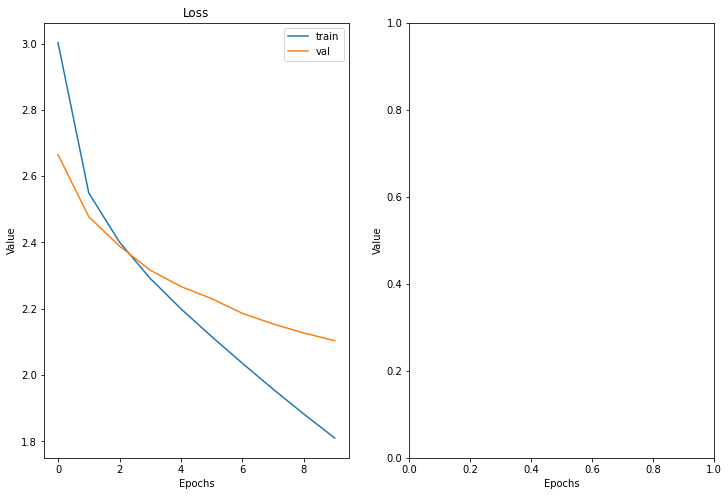

In [51]:
plot_curve(history.epoch, history.history, ['loss', 'val_loss'])

In [52]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=15):
    # 테스트를 위해서 입력받은 init_sentence도 일단 텐서로 변환하기
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 텍스트를 실제로 생성할때는 루프를 돌면서 단어 하나씩 생성 
    while True:
        predict = model(test_tensor)  # 입력받은 문장의 텐서를 입력
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]   # 우리 모델이 예측한 마지막 단어가 바로 새롭게 생성한 단어가 된다. 

        # 우리 모델이 새롭게 예측한 단어를 입력 문장의 뒤에 붙여 주기
        test_tensor = tf.concat([test_tensor, 
                                                                 tf.expand_dims(predict_word, axis=0)], axis=-1)

        # 우리 모델이 <END>를 예측했거나, max_len에 도달하지 않았다면  while 루프를 또 돌면서 다음 단어를 예측
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # 생성된 tensor 안에 있는 word index를 tokenizer.index_word 사전을 통해 실제 단어로 하나씩 변환한다. 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated   # 이것이 최종적으로 모델이 생성한 자연어 문장이다.

In [53]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=15)

'<start> i love you , i m not gonna crack <end> '

# 회고

### 1)결과 
embedding_size = 1024, hidden_size = 2048 을 했을 때 loss값은 떨어지고 val_loss값은 증가하는 overfitting현상이 일어났다. embedding_size = 19, hidden_size = 1024로 바꾼 후 다시 학습시킨 결과. val_loss값이 2.2이하인 2.1040까지 떨어지는 모습을 보였다.

### 2) 개념
(1)epoch
- 한 번의 epoch는 인공 신경망에서 전체 데이터 셋에 대해 forward pass/backward pass 과정을 거친 것을 말함. 즉, 전체 데이터 셋에 대해 한 번 학습을 완료한 상태이다.  

(2)batch size , iteration  
- batch size는 한 번의 batch마다 주는 데이터 샘플의 size. 여기서 batch(보통 mini-batch라고 표현)는 나눠진 데이터 셋을 뜻하며 iteration는 epoch를 나누어서 실행하는 횟수라고 생각하면 된다. 이때 몇 번 나누어서 주는가를 iteration, 각 iteration마다 주는 데이터 사이즈를 batch size라고 한다.

(3)embedding
- Embedding 레이어는 입력으로 들어온 단어를 분산 표현으로 연결해 주는 역할을 하는데 그것이 Weight에서 특정 행을 읽어오는 것과 같아 이 레이어를 룩업 테이블(Lookup Table) 이라고 부르기도 합니다.  Embedding 레이어는 입력에 직접 연결되게 사용해야 한다는 것을 꼭 기억하기! 그리고 그 입력은 원-핫 인코딩된 단어 벡터의 형태일 때가 이상적입니다.